## Package Installation

In [32]:
# install ase and amp
!pip3 install amp-atomistics
!pip install ase
# !sudo apt update && sudo apt install nwchem
# Install Nwchem
!sudo apt update
!sudo apt -y install mpi-default-bin libgfortran4 libopenblas-base \
libopenmpi2 libscalapack-openmpi2.0 openmpi-bin libquadmath0 \
libfabric1 libhwloc5 libibverbs1 libpsm-infinipath1 \
openmpi-common libhwloc-plugins libnl-route-3-200 \
ocl-icd-libopencl1  librdmacm1
!wget https://github.com/nwchemgit/nwchem/releases/download/6.8.1-release/nwchem-data_6.8.1+133+gitge032219-2_all.ubuntu_bionic.deb
!wget https://github.com/nwchemgit/nwchem/releases/download/6.8.1-release/nwchem_6.8.1+133+gitge032219-2_amd64.ubuntu_bionic.deb
!sudo dpkg -i nwchem_6.8.1+133+gitge032219-2_amd64.ubuntu_bionic.deb nwchem-data_6.8.1+133+gitge032219-2_all.ubuntu_bionic.deb

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Reading package lists... Done
Building dependency tree       
Reading state information... Done
39 packages can be upgraded. Run 'apt

## Import necessary packages and functions

In [0]:
from __future__ import print_function

from ase.cluster.cubic import FaceCenteredCubic
from ase.optimize import QuasiNewton
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.build import molecule
from ase.calculators.nwchem import NWChem

from ase.io import read, Trajectory
from amp import Amp

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### NWChem DFT MD calculation

In [38]:
%%time
# Set up a atom project
pos = [1.1*0.969, 1.*0.969] #[r1, r2, theta]

atoms = molecule('H2O')
atoms.cell = np.array(np.diag([15, 15.1, 15.2]))
# water.set_angle(1, 0, 2, pos[2])
atoms.set_distance(0, 1, pos[0], fix=0)
atoms.set_distance(0, 2, pos[1], fix=0)
atoms.center()
print(atoms.get_positions())

# atoms.set_calculator(EMT())
calc = NWChem(label='calc/nwchem', maxiter=2000, xc='B3LYP', basis='6-31+G**')
atoms.set_calculator(calc)
atoms.get_potential_energy()
atoms.get_kinetic_energy()

%rm -rf dft.traj
traj = Trajectory('dft_md.traj', 'w')
traj.write(atoms)

# Do a quick relaxation of the cluster
# qn = QuasiNewton(atoms)
# qn.run(0.001, 10)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, 300* units.kB)
Stationary(atoms)  # zero linear momentum
ZeroRotation(atoms)  # zero angular momentum

# We want to run MD using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1.5 * units.fs)

def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    traj.write(a)

dyn.attach(printenergy, interval=1)

# Now run the dynamics
printenergy()
dyn.run(10)

[[7.5        7.51182091 7.92811724]
 [7.5        8.35176086 7.27188276]
 [7.5        6.74823914 7.33154044]]
Energy per atom: Epot = -693.222eV  Ekin = 0.055eV (T=428K)  Etot = -693.167eV
Energy per atom: Epot = -693.222eV  Ekin = 0.055eV (T=428K)  Etot = -693.167eV
Energy per atom: Epot = -693.232eV  Ekin = 0.067eV (T=518K)  Etot = -693.165eV
Energy per atom: Epot = -693.199eV  Ekin = 0.035eV (T=273K)  Etot = -693.164eV
Energy per atom: Epot = -693.245eV  Ekin = 0.064eV (T=492K)  Etot = -693.182eV
Energy per atom: Epot = -693.219eV  Ekin = 0.051eV (T=396K)  Etot = -693.168eV
Energy per atom: Epot = -693.191eV  Ekin = 0.027eV (T=206K)  Etot = -693.164eV
Energy per atom: Epot = -693.234eV  Ekin = 0.061eV (T=471K)  Etot = -693.173eV
Energy per atom: Epot = -693.243eV  Ekin = 0.063eV (T=487K)  Etot = -693.180eV
Energy per atom: Epot = -693.176eV  Ekin = 0.031eV (T=238K)  Etot = -693.145eV
Energy per atom: Epot = -693.263eV  Ekin = 0.085eV (T=658K)  Etot = -693.178eV
Energy per atom: Epot 

### AMP MD Calculation

In [4]:
from google.colab import files
files.upload()

Saving dft_md_noqn.traj to dft_md_noqn.traj


{'dft_md_noqn.traj': b'- of UlmASE-Trajectory  \x03\x00\x00\x00\x00\x00\x00\x00\xeb\x03\x00\x00\x00\x00\x00\x00\x80p\x00\x00\x00\x00\x00\x00\xe0\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1e@333333\x1e@[\x051\xd0\xb5\x97\x1f@\x00\x00\x00\x00\x00\x00\x1e@\xda\xa9\xb9\xdc`\xa0 @q\xc7\x9b\xfc\x165\x1d@\x00\x00\x00\x00\x00\x00\x1e@\xb2\x12\xf3\xac\xa4%\x1b@q\xc7\x9b\xfc\x165\x1d@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80<\xa6\xd5\x838[\xc0\xbf\x00\x00\x00\x00\x00\x00\x00\x80:ZC\x12\x03\xe2\xbe?\xe3M\xc9\'\x89Y\xb0?\x00\x00\x00\x00\x00\x00\x00\x80:ZC\x12\x03\xe2\xbe\xbf\xe3M\xc9\'\x89Y\xb0?\xd9\x01\x00\x00\x00\x00\x00\x00{"version": 1, "ase_version": "3.18.0", "pbc": [false, false, false], "numbers.": {"ndarray": [[3], "int64", 56]}, "positions.": {"ndarray": [[3, 3], "float64", 80]}, "cell": [[15.0, 0.0, 0.0], [0.0, 15.1, 0.0], [0.0, 0.0, 15.2]], "calculator.": {"

In [0]:
%%time
# !rm -rf amp-* amp.traj nwchem.traj
!ls

amp_md_noqn.traj  dft_md_noqn.traj  sample_data
CPU times: user 23.8 ms, sys: 9.55 ms, total: 33.4 ms
Wall time: 3.23 s


In [28]:
%%time

# Set up a atom project
pos = [1.1*0.969, 1.*0.969] #[r1, r2, theta]

atoms = molecule('H2O')
atoms.cell = np.array(np.diag([15, 15.1, 15.2]))
# water.set_angle(1, 0, 2, pos[2])
atoms.set_distance(0, 1, pos[0], fix=0)
atoms.set_distance(0, 2, pos[1], fix=0)
atoms.center()

print(atoms.get_positions())

calc = Amp.load('amp.amp')
atoms.set_calculator(calc)
atoms.get_potential_energy()
atoms.get_kinetic_energy()

%rm -rf amp_md.traj
traj = Trajectory('amp_md.traj', 'w')
traj.write(atoms)

# qn = QuasiNewton(atoms)
# qn.run(0.001, 10)

MaxwellBoltzmannDistribution(atoms, 300.* units.kB)
Stationary(atoms)  # zero linear momentum
ZeroRotation(atoms)  # zero angular momentum

dyn = VelocityVerlet(atoms, 1.5 * units.fs)

def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    traj.write(a)
dyn.attach(printenergy, interval=0)

#Now run the dynamics
# printenergy()

dyn.run(1000)

[[7.5        7.51182091 7.92811724]
 [7.5        8.35176086 7.27188276]
 [7.5        6.74823914 7.33154044]]


FileNotFoundError: ignored

## Result Analysis

In [0]:
from google.colab import files
files.upload()

Saving amp_md_noqn.traj to amp_md_noqn.traj


{'amp_md_noqn.traj': b'- of UlmASE-Trajectory  \x03\x00\x00\x00\x00\x00\x00\x00\xeb\x03\x00\x00\x00\x00\x00\x00\x98Y\x00\x00\x00\x00\x00\x00\x98\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1e@333333\x1e@[\x051\xd0\xb5\x97\x1f@\x00\x00\x00\x00\x00\x00\x1e@\xda\xa9\xb9\xdc`\xa0 @q\xc7\x9b\xfc\x165\x1d@\x00\x00\x00\x00\x00\x00\x1e@\xb2\x12\xf3\xac\xa4%\x1b@q\xc7\x9b\xfc\x165\x1d@6\x01\x00\x00\x00\x00\x00\x00{"version": 1, "ase_version": "3.18.0", "pbc": [false, false, false], "numbers.": {"ndarray": [[3], "int64", 56]}, "positions.": {"ndarray": [[3, 3], "float64", 80]}, "cell": [[15.0, 0.0, 0.0], [0.0, 15.1, 0.0], [0.0, 0.0, 15.2]], "calculator.": {"name": "amp", "parameters": {}, "energy": -2079.558377877068}}##\x00\x00\x00\x00\x00\x00\x1e@333333\x1e@[\x051\xd0\xb5\x97\x1f@\x00\x00\x00\x00\x00\x00\x1e@\xda\xa9\xb9\xdc`\xa0 @q\xc7\x9b\xfc\x165\x1d@\x00\x00\x00\x00\x00\x00\x1e@\xb2\x12

In [40]:
amp_file = 'amp_md_noqn.traj'
dft_file = 'dft_md_noqn.traj'
# dft_file = 'dft_md.traj'

amp_md = read(amp_file, index=':')
amp_positions = []
amp_potential, amp_kinetic = [], []
amp_angles, amp_r = [], []
for i in range(len(amp_md)):
    amp_positions.append(amp_md[i].get_positions())
    amp_potential.append(amp_md[i].get_potential_energy())
    amp_kinetic.append(amp_md[i].get_kinetic_energy())
    amp_angles.append(amp_md[i].get_angle(1,0,2))
    amp_r.append(amp_md[i].get_distances(0,[1,2]))
amp_positions = np.array(amp_positions)
amp_potential = np.array(amp_potential)
amp_kinetic = np.array(amp_kinetic)
print(amp_positions.shape)

dft_md = read(dft_file, index=':')
dft_positions = []
dft_potential, dft_kinetic = [], []
dft_angles, dft_r = [], []
for i in range(len(dft_md)):
    dft_positions.append(dft_md[i].get_positions())
    dft_potential.append(dft_md[i].get_potential_energy())
    dft_kinetic.append(dft_md[i].get_kinetic_energy())
    dft_angles.append(dft_md[i].get_angle(1,0,2))
    dft_r.append(dft_md[i].get_distances(0,[1,2]))
dft_positions = np.array(dft_positions)
dft_potential = np.array(dft_potential)
dft_kinetic = np.array(dft_kinetic)
print(dft_positions.shape)
rmse = np.sqrt(np.mean(np.absolute(amp_positions - dft_positions)**2))
print(rmse)

(1003, 3, 3)
(1003, 3, 3)
0.04438210803853363


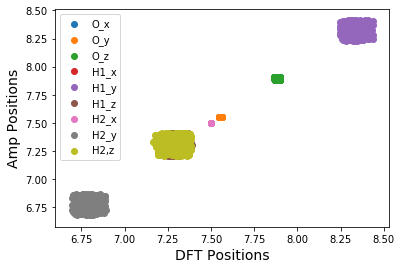

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
labels = np.array([['O_x', 'O_y', 'O_z'], ['H1_x', 'H1_y', 'H1_z'], ['H2_x', 'H2_y', 'H2,z']])
for i in range(3):
    for j in range(3):
      plt.scatter(dft_positions[:,i,j], amp_positions[:,i,j], label=labels[i,j])
plt.xlabel('DFT Positions', fontsize=14)
plt.ylabel('Amp Positions', fontsize=14)
plt.legend()
plt.show()

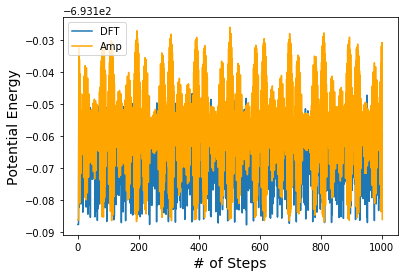

In [0]:
plt.figure()
plt.plot(np.arange(len(dft_potential)), dft_potential/3, label='DFT')
plt.plot(np.arange(len(amp_potential)), amp_potential/3, c='orange', label='Amp')
plt.xlabel('# of Steps', fontsize=14)
plt.ylabel('Potential Energy', fontsize=14)
plt.legend()
plt.show()

### Calculate Correlation Function


(1003, 1)


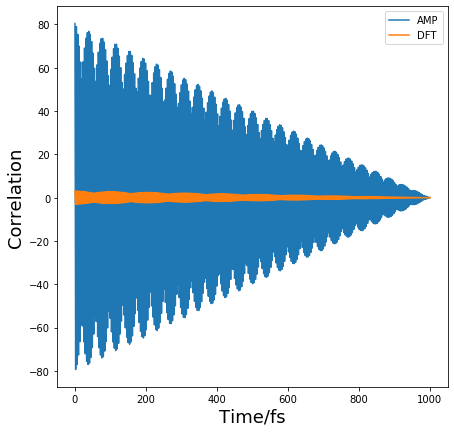

In [51]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal

# define the correlation function
def autocorr(X, use_mean=True, div_dims=True, div_biased=True, use_var=False):
    # Method works if X has an even number of rows
    if (X.shape[0] % 2):
        X = X[:-1, ]
    # Calculate mean (if selected)
    X_avg = 0.0
    if use_mean:
        X_avg = np.mean(X)
    # Set up cfxn calc
    T = X.shape[0]
    N = X.shape[1]
    cfxn = np.zeros(T)
    # Cfxn
    for n in range(N):
        a = X[:, n] * 1.0
        a -= X_avg
        b = np.zeros(T * 2)
        # Zero padding of half the datasize on each end of b
        b[int(T/2): int(T/2 + T)] = a
        # Do an array flipped convolution, which is a correlation.
        c = signal.fftconvolve(b, a[::-1], mode='same')[T:]
        cfxn += c
    # Divide cfxn by T,N, and/or variance (if selected)
    if div_dims:
        cfxn /= N
        if div_biased:
            cfxn /= T  # Divide by T
        else:
            cfxn /= np.arange(T, 0, -1)  # Or divide by T-tau
    if use_var:
        cfxn /= X.var()
    return cfxn
print(np.array(amp_angles).reshape((-1,1)).shape)
amp_cor = autocorr(np.array(amp_angles).reshape((-1,1)),use_mean=True, div_dims=True, div_biased=True, use_var=False)
dft_cor = autocorr(np.array(dft_angles).reshape((-1,1)), use_mean=True, div_dims=True, div_biased=True, use_var=False)
# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,7))
# ax.plot(np.arange(len(amp_positions)), amp_positions[:,0,1])
ax.plot(amp_cor, label='AMP')
ax.plot(dft_cor, label='DFT')
ax.set_xlabel('Time/fs', fontsize=18)
ax.set_ylabel('Correlation', fontsize=18)
ax.legend()
# ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

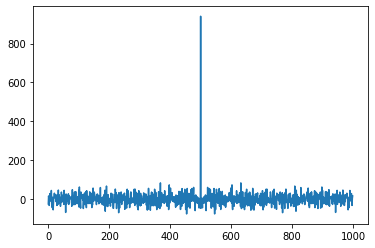

In [27]:
from scipy import signal
sig = np.random.randn(1000)
autocorr = signal.fftconvolve(sig, sig[::-1], mode='same')
plt.plot(autocorr)